# Tool calling with gpt-oss

The [OpenAI Harmony Response Format](https://cookbook.openai.com/articles/openai-harmony#handling-reasoning-output-in-subsequent-sampling) states that the chain-of-thought (CoT) from prior turns, up to the last final message, should be sent on subsequent sampling:

> In general, you should drop any previous CoT content on subsequent sampling if the responses by the assistant ended in a message to the final channel.

> The exception for this is tool/function calling. The model is able to call tools as part of its chain-of-thought and because of that, we should pass the previous chain-of-thought back in as input for subsequent sampling. Check out the function calling section for a complete example.

This is further explained in [How to handle the raw chain of thought in gpt-oss](https://cookbook.openai.com/articles/gpt-oss/handle-raw-cot):

> If the last message by the assistant was a tool call of any type, the analysis messages until the previous final message should be preserved on subsequent sampling until a final message gets issued

However, most clients do _not_ pass the CoT back to the model during tool calling. This notebook evaluates the performance of gpt-oss on a multi-turn tool calling task, comparing how most clients currently operate (without passing CoT) to the recommended approach (with CoT).

In [8]:
import httpx
import json
import re
import time
import os

from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown

## Task

1. Ask gpt-oss to get the weather for N cities
2. Process tool calls and provides results back to the gpt-oss, including the CoT in tool call messages if the flag is set
3. Continue the conversation until finished or hit the max turns (25)

In [9]:
weather = {
    "new york city": "51F",
    "denver": "52F",
    "chicago": "47F",
    "austin": "72F",
    "seattle": "56F",
    "boston": "54F",
    "new orleans": "61F",
    "las vegas": "69F",
    "los angeles": "68F",
    "miami": "79F",
    "phoenix": "75F",
    "portland": "53F",
    "san francisco": "62F",
    "atlanta": "58F",
    "dallas": "66F",
    "minneapolis": "42F",
    "philadelphia": "52F",
    "san diego": "67F",
}

weather_cities = list(weather.keys())

def get_weather(city: str):
    if city.lower() not in weather:
        return f"No weather data for {city}"
    return f"{city}: {weather[city.lower()]}"


get_weather_tool = {
    "type": "function",
    "function": {
        "name": "get_weather",
        "description": "Obtain the weather for a given city.",
        "parameters": {
            "type": "object",
            "properties": {
                "city": {
                    "type": "string",
                    "description": "City",
                },
            },
            "required": ["city"],
        },
    },
}


def dig(obj, path, default=None):
    if isinstance(path, str):
        path = [int(k) if k.isdigit() else k for k in path.split('.')]
    
    if not path:
        return obj
    
    current = obj
    for key in path:
        try:
            if isinstance(current, dict):
                current = current[key]
            elif isinstance(current, list):
                if not isinstance(key, int):
                    return default
                current = current[key]
            else:
                return default
        except (KeyError, IndexError, TypeError):
            return default
    
    return current

In [10]:
def run_trial(f, include_reasoning: bool, num_cities: int = len(weather_cities)):
    cities = weather_cities[:num_cities]
    prompt = "Get the weather for the following cities and tabulate the results: " + ", ".join(cities)
    payload = {
        "messages": [{
            "role": "user",
            "content": prompt,
        }],
        "tools": [get_weather_tool]
    }

    expect_calls = {c.lower(): 1 for c in cities}
    actual_calls = {}

    f.write("# Trial\n\n")
    f.write("## Conversation\n\n")
    
    for n in range(25):
        try:
            with httpx.Client() as client:
                resp = client.post("http://localhost:8080/v1/chat/completions", json=payload, timeout=300)
            resp.raise_for_status()
        except:
            time.sleep(0.5)
            continue
            
        data = resp.json()
    
        finish_reason = dig(data, "choices.0.finish_reason")
        message = dig(data, "choices.0.message", {})
        reasoning = dig(message, "reasoning_content", dig(message, "reasoning", ""))
        content = dig(message, "content", "")
        tool_calls = dig(message, "tool_calls", [])
    
        cleaned_message = message.copy()
    
        if include_reasoning:
            # Keep `reasoning_content` in the message, but remove `content` if it exists.
            if reasoning and content:
                cleaned_message.pop("content", None)
        else:
            # Remove `reasoning_content` from the message. This is how most clients behave.
            cleaned_message.pop("reasoning_content", None)
            cleaned_message.pop("reasoning", None)
            
        payload["messages"].append(cleaned_message)
    
        if tool_calls:
            tool_call_id = dig(tool_calls, "0.id", "")
            tool_call_name = dig(tool_calls, "0.function.name", "")
            tool_call_args = dig(tool_calls, "0.function.arguments", "")
            parsed_args = json.loads(tool_call_args)
    
            city = dig(parsed_args, "city", "")
            weather = get_weather(city)
            actual_calls[city.lower()] = actual_calls.get(city.lower(), 0) + 1
    
            payload["messages"].append({
                "role": "tool",
                "tool_call_id": tool_call_id,
                "content": weather,
            })
    
        raw_prompt = dig(data, "__verbose.prompt", "")
        raw_content = dig(data, "__verbose.content", "")
    
        complete_msg = raw_prompt + raw_content
        if finish_reason == "tool_calls":
            complete_msg += "<|call|>"
        else:
            complete_msg += "<|return|>"

        harmony_messages = []
    
        last = 0
        for match in re.finditer(r"<\|start\|>.*?(<\|(call|end|return)\|>|$)", complete_msg, re.DOTALL):
            msg = match.group(0)
            harmony_messages.append(msg)
            last = match.end()
    
        remaining = complete_msg[last:]

        f.write(f"### Turn {n+1}\n\n")
        f.write("```\n")
        f.write("\n\n".join(harmony_messages))
        if remaining:
            f.write("\n\n"+remaining)
        f.write("\n```\n\n")
    
        if finish_reason != "tool_calls":
            break

    f.write("## Results\n\n")
    f.write("expect calls:\n```json\n" + json.dumps(expect_calls, indent=2) + "\n```\n\n")
    f.write("actual calls:\n```json\n" + json.dumps(actual_calls, indent=2) + "\n```\n\n")

    passed = 1 if all(actual_calls.get(x, 0) > 0 for x in expect_calls) else 0
    total_calls = sum(actual_calls.values())

    true_positives = 0
    false_negatives = 0
    for exp in expect_calls:
        if actual_calls.get(exp, 0) > 0:
            # Consider a call made to be a true positive
            true_positives += 1
            # Decrement the count so we consider extraneous calls as false positives
            actual_calls[exp] -= 1
            
        else:
            false_negatives += 1
    
    false_positives = unnecessary_calls = sum(actual_calls.values())

    precision = true_positives / (true_positives + false_positives) if actual_calls else 0
    recall = true_positives / (true_positives + false_negatives) if expect_calls else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    f.write("```\n")
    f.write(f"             pass: {passed}\n")
    f.write(f"      total calls: {total_calls}\n")
    f.write(f"unnecessary calls: {unnecessary_calls}\n")
    f.write(f"   true positives: {true_positives}\n")
    f.write(f"  false positives: {false_positives}\n")
    f.write(f"  false negatives: {false_negatives}\n")
    f.write(f"        precision: {precision}\n")
    f.write(f"           recall: {recall}\n")
    f.write(f"         F1 score: {f1_score}\n")
    f.write("```\n")
    
    return {
        "prompt": prompt,
        "passed": passed,
        "total_calls": total_calls,
        "unnecessary_calls": unnecessary_calls,
        "expected_calls": len(expect_calls),
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }

In [11]:
def run_experiment(output_dir: str, include_reasoning: bool, num_cities: int = len(weather_cities), trials: int = 5, workers: int = 5):
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "results.csv")

    try:
        # Return cached response.
        return pd.read_csv(output_path)
    except:
        pass

    def run_single(id: int):
        with open(os.path.join(output_dir, f"trial-{id}.md"), "w") as f:
            return {"trial": id, **run_trial(f, include_reasoning, num_cities)}
    
    with ThreadPoolExecutor(max_workers=workers) as executor:
        results = pd.DataFrame(
            executor.map(run_single, range(trials)),
        ).set_index("trial")

    results.to_csv(output_path)
    return results


def experiment_path(provider: str, n: int, cities: int, cot: bool):
    return f"experiments/provider={provider}/n={n}/cities={cities}/cot={str(cot).lower()}"

## Experiments

Run experiments with different parameters.

In [12]:
test_n = [25]
test_cities = [1, 5, 10, 15]
test_cot = [False, True]
provider = "llama.cpp"

In [13]:
for n in test_n:
    for cities in test_cities:
        for cot in test_cot:
            run_experiment(experiment_path(provider, n, cities, cot), cot, cities, trials=n, workers=50)

### Results

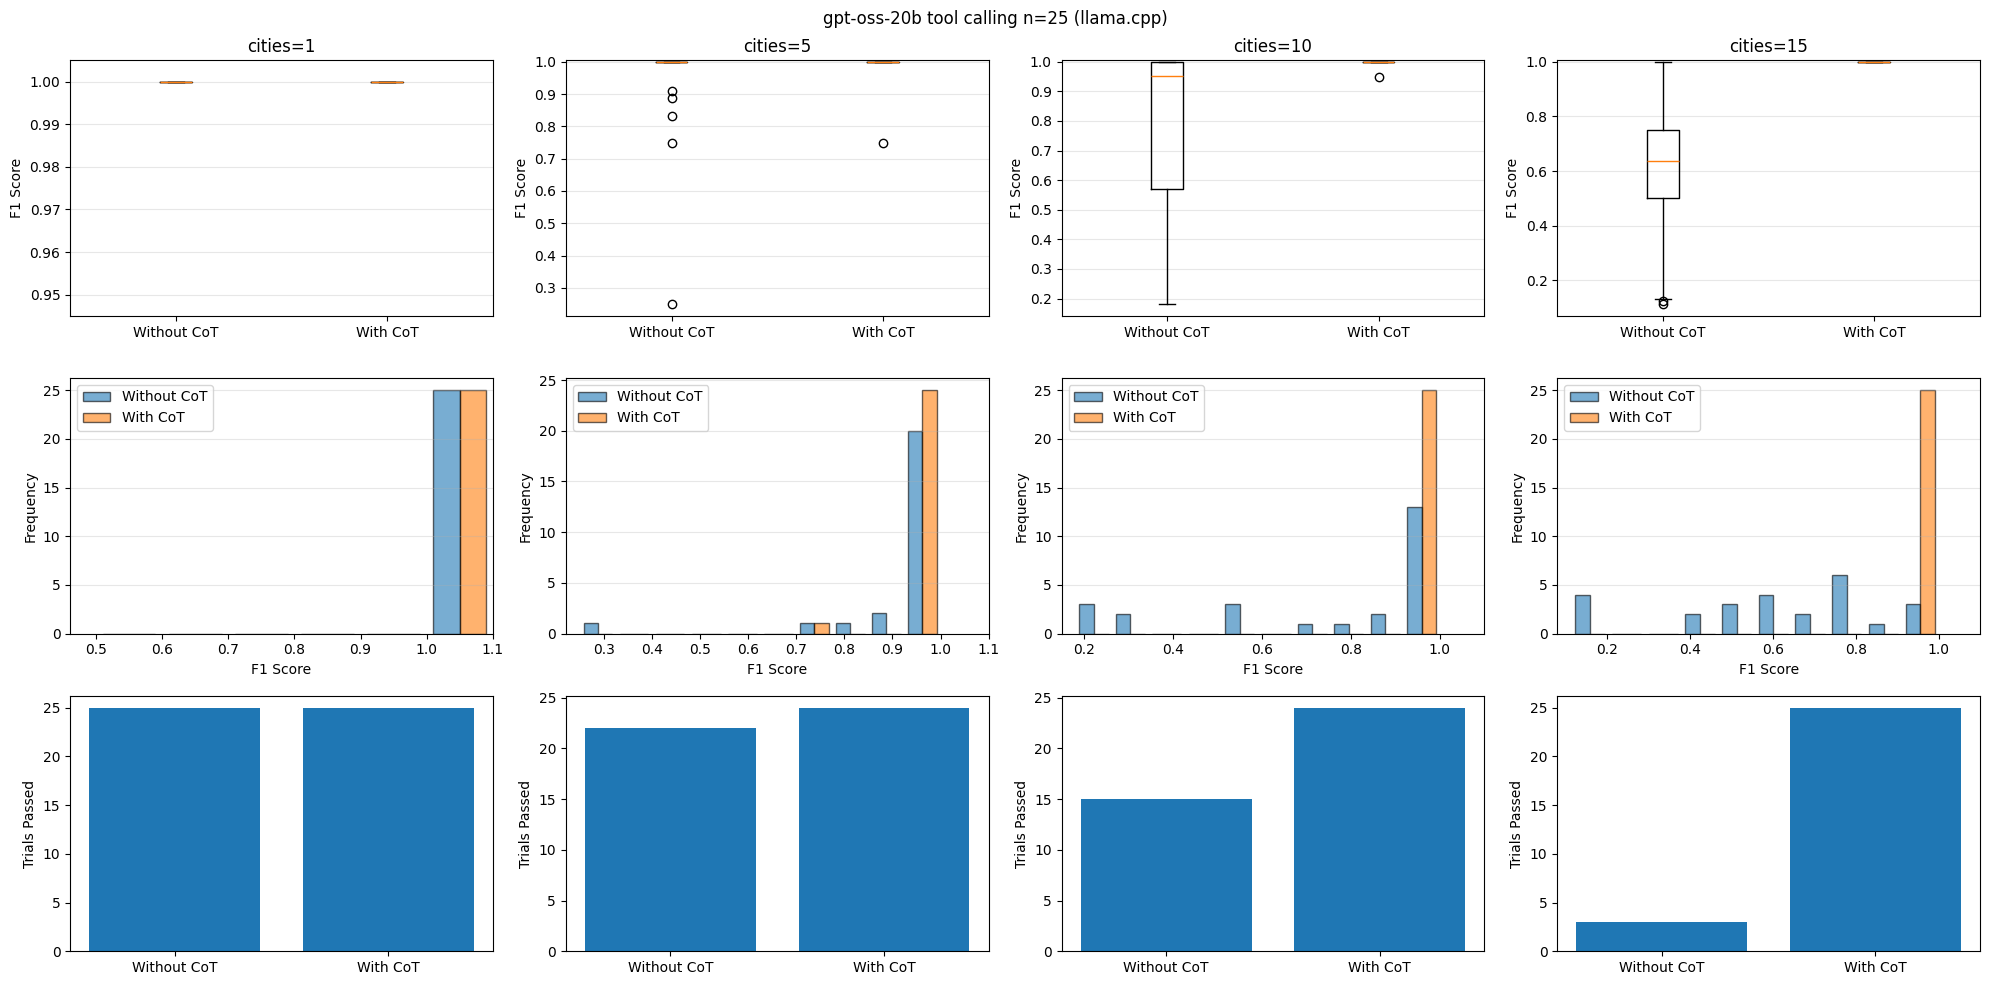

In [17]:
for provider in ["llama.cpp"]:
    for n in test_n:
        fig, axes = plt.subplots(3, len(test_cities), figsize=(len(test_cities)*5, 10))
        fig.suptitle(f"gpt-oss-20b tool calling n={n} ({provider})")
        
        for i, cities in enumerate(test_cities):
            f1_scores = []
            passed = []
            labels = []
            for cot in test_cot:
                results = pd.read_csv(os.path.join(experiment_path(provider, n, cities, cot), "results.csv"))
                f1_scores.append(results["f1_score"])
                passed.append(results["passed"].sum())
                labels.append("With CoT" if cot else "Without CoT")
                
            boxplot = axes[0][i]
            boxplot.boxplot(f1_scores, tick_labels=labels)
            boxplot.set_ylabel("F1 Score")
            boxplot.set_title(f"cities={cities}")
            boxplot.grid(True, alpha=0.3, axis='y')
            boxplot.set_ylim(None, 1.005)  # F1-scores range from 0 to 1
    
            hist = axes[1][i]
            hist.hist(f1_scores, label=labels, bins=10, alpha=0.6, edgecolor="black", align="mid")
            hist.set_xlabel('F1 Score')
            hist.set_ylabel('Frequency')
            hist.legend()
            hist.grid(True, alpha=0.3, axis='y')
            hist.set_xlim(None, 1.10)  # F1-scores range from 0 to 1
    
            passed_plot = axes[2][i]
            passed_plot.bar(labels, passed)
            passed_plot.set_ylabel("Trials Passed")
    
        fig.tight_layout()
        fig.savefig(f"experiments/provider={provider}/n={n}/results.svg")
        fig.savefig(f"experiments/provider={provider}/n={n}/results.png")